In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from msc_project.utils.fit_NLS import *

plt.style.use('ggplot')

In [2]:
def plot_size_n(data_path, polarization_fit_path, tau_fit_path, size, n, n_tol, savefig=None,
                tau_fit_fixn_path=None, tau_fit_exclude_path=None, tau_fit_fixn_exclude_path=None, format=0, manual_data_override=None):
    # read data
    if manual_data_override is not None:
        data = manual_data_override
    else:
        ext = '.csv' if format != 2 else '.txt'
        csv_files = [f for f in os.listdir(data_path) if f.endswith(ext)]
        size_csv_file = None
        for csv_file in csv_files:
            if f"{size} nm" in csv_file:
                size_csv_file = csv_file
                break
        if size_csv_file is None:
            raise ValueError(f"Couldn't find data for size {size}")
        data = load_data(os.path.join(data_path, size_csv_file), format=format)

    fit_df = pd.read_csv(polarization_fit_path)
    tau_fit_df = None if tau_fit_path is None else pd.read_csv(tau_fit_path)
    tau_fit_fixn_df = None if tau_fit_fixn_path is None else pd.read_csv(tau_fit_fixn_path)
    tau_fit_exclude_df = None if tau_fit_exclude_path is None else pd.read_csv(tau_fit_exclude_path)
    tau_fit_fixn_exclude_df = None if tau_fit_fixn_exclude_path is None else pd.read_csv(tau_fit_fixn_exclude_path)

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(f"Size: {size} nm, n={n}")

    # plot polarization vs. pulse duration with fit on the left
    size_df = fit_df[fit_df['size'] == size]
    size_n_df = size_df[np.isclose(size_df['n'], n, atol=n_tol*1.1)]

    t = np.logspace(np.log10(data['Pulse Width'].min()), np.log10(data['Pulse Width'].max()), 1000)

    if not size_n_df.empty:
        norm = clr.Normalize()
        cmap = plt.cm.plasma
        colors = cmap(norm(data.columns[1:].astype(float)))
        cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), ax=axs[0])
        cbar.set_label("V")

        for col, c in zip(data.columns[1:], colors):
            axs[0].scatter(data["Pulse Width"], data[col], color=c)
            # plot fit
            popt = size_n_df[size_n_df['voltage'] == float(col)].values
            if len(popt) == 0:
                continue
            r2 = popt[0][-1]
            popt = popt[0][2:-1]
            n, A, omega, log_tlorentz = popt
            p = polarization_lorentzian(t, A, omega, log_tlorentz, n)
            label = f'{col}V: $A$={A:.2f}, $\\omega$={omega:.2f}, $\\log(\\tau_{{Lorentz}})$={log_tlorentz:.2f}, $n$={n:.2f}, ($R^2$={r2:.3f})'
            axs[0].plot(t, p, color=c, label=label)

        # plot tau vs. voltage with fit on the right
        axs[1].scatter(size_n_df['voltage'], size_n_df['log_tlorentz'], label="$\\tau_{Lorentz}$ (exp.)")

        tau_dfs = [tau_fit_df, tau_fit_fixn_df, tau_fit_exclude_df, tau_fit_fixn_exclude_df]
        notes = ["", ", fixed n", ", exclude low/high voltages", ", fixed n & exclude low/high voltages"]
        for df, note in zip(tau_dfs, notes):
            if df is not None:
                popt = df[(df['size'] == size) & np.isclose(df['n'], n, atol=n_tol*1.1)].values
                if popt is not None and len(popt) > 0:
                    r2 = popt[0][-1]
                    popt = popt[0][2:-1]
                    v = np.linspace(size_n_df['voltage'].min(), size_n_df['voltage'].max(), 1000)
                    label = f'$\\log(\\tau_{{Lorentz}})$ (fit{note}): $\\tau_0$={popt[0]:.2e}, $V_0$={popt[1]:.2f}, $n$={popt[2]:.2f}, ($R^2$={r2:.3f})'
                    t = f_tau(v, *popt)
                    axs[1].plot(v, np.log(t), label=label)

    axs[0].set(xlabel='Pulse duration', ylabel='Partial polarization', xscale='log', ylim=(0, 1))
    axs[0].legend()
    axs[1].set(xlabel='Voltage', ylabel='$\\log(\\tau_{{lorentz}})$')
    axs[1].legend()
    plt.tight_layout()

    if savefig is not None:
        plt.savefig(savefig)
    else:
        plt.show()

In [3]:
def plot_polarization_with_fit(ax, pulse_width, partial_pol, polarization_fit, **kwargs):
    ax.scatter(pulse_width, partial_pol, **kwargs)


    voltage = polarization_fit[1]
    r2 = polarization_fit[-1]
    popt = polarization_fit[2:-1]
    n, A, omega, log_tlorentz = popt

    label = f'{voltage}V: $A$={A:.2f}, $\\omega$={omega:.2f}, $\\log(\\tau_{{Lorentz}})$={log_tlorentz:.2f}, $n$={n:.2f}, ($R^2$={r2:.3f})'

    t = np.logspace(np.log10(pulse_width.min()), np.log10(pulse_width.max()), 1000)
    p = polarization_lorentzian(t, A, omega, log_tlorentz, n)

    ax.plot(t, p, label=label, **kwargs)

def plot_all_polarizations_with_fit(ax, exp_data, polarization_fits):
    norm = clr.Normalize()
    cmap = plt.cm.plasma
    colors = cmap(norm(exp_data.columns[1:].astype(float)))
    cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)
    cbar.set_label("V")

    for col, c in zip(exp_data.columns[1:], colors):
        polarization_fit = polarization_fits[polarization_fits['voltage'] == float(col)]
        if len(polarization_fit) == 0:
            print(f"No fit data for {col}V")
            continue
        elif len(polarization_fit) > 1:
            print(f"Multiple fits found for {col}V")
            continue

        plot_polarization_with_fit(ax, exp_data["Pulse Width"], exp_data[col], polarization_fit.values[0], color=c)

def plot_tau_l_with_fit(ax, voltage, log_tlorentz, tau_fit, inverse_v=False, **kwargs):
    ax.scatter(voltage, log_tlorentz, **kwargs)

    popt = tau_fit[2:-1]
    r2 = tau_fit[-1]

    label = f'$\\log(\\tau_{{Lorentz}})$ (fit): $\\tau_0$={popt[0]:.2e}, $V_0$={popt[1]:.2f}, $n$={popt[2]:.2f}, ($R^2$={r2:.3f})'

    v = np.linspace(voltage.min(), voltage.max(), 1000)
    t = f_tau(v, *popt)
    if inverse_v:
        v = 1/v

    ax.plot(v, np.log(t), label=label, **kwargs)

def plot_all_with_fit(axs, exp_data, polarization_fits, tau_fits_pos, tau_fits_neg):
    plot_all_polarizations_with_fit(axs[0], exp_data, polarization_fits)

    voltage = polarization_fits[polarization_fits['voltage'] > 0]['voltage']
    if len(voltage) > 0:
        log_tlor = polarization_fits[polarization_fits['voltage'] > 0]['log_tlorentz']
        plot_tau_l_with_fit(axs[1], voltage, log_tlor, tau_fits_pos.values[0])

    voltage = polarization_fits[polarization_fits['voltage'] < 0]['voltage']
    if len(voltage) > 0:
        log_tlor = polarization_fits[polarization_fits['voltage'] < 0]['log_tlorentz']
        plot_tau_l_with_fit(axs[1], voltage, log_tlor, tau_fits_neg.values[0])



In [9]:
# DATA_PATH = '/Users/pauluv/Documents/Code/msc_project/data/Data_for_NLS'
DATA_PATH = '/scratch/msc24h18/msc_project/data/Data_for_NLS'
RESULTS_DIR = '/scratch/msc24h18/msc_project/results/nls_model'

#results_subdir = os.path.join(RESULTS_DIR, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
results_subdir = '/scratch/msc24h18/msc_project/results/nls_model/20250122_144739'
polarization_fits_path = os.path.join(results_subdir, 'polarization_fits.csv')
tau_fits_path = os.path.join(results_subdir, 'tau_fits.csv')
tau_fits_path_neg = os.path.join(results_subdir, 'tau_fits_neg.csv')
tau_fits_path_exclude = os.path.join(results_subdir, 'tau_fits_exclude.csv')

if not os.path.exists(results_subdir):
    os.makedirs(results_subdir)

n_vals = np.linspace(0.5, 2.5, 21)
n_tol = 0.01

#fit_polarizations(DATA_PATH, n_vals, n_tol, polarization_fits_path, format=0)

In [ ]:
fix_V0 = None
exclude_voltages = [1, 1.25, 1.5, 4.5, 4.75, 5]
# fit_tau_lorentz(polarization_fits_path, n_vals, n_tol, fix_n_tau=False, exclude_voltages=None, output_file=tau_fits_path, fix_V0=5)
# fit_tau_lorentz(polarization_fits_path, n_vals, n_tol, fix_n_tau=True, exclude_voltages=None, output_file=tau_fits_path_fixn, fix_V0=5)
# fit_tau_lorentz(polarization_fits_path, n_vals, n_tol, fix_n_tau=False, exclude_voltages=[1, 1.25, 1.5, 4.5, 4.75, 5], output_file=tau_fits_path_exclude3, fix_V0=5)

fit_tau_lorentz(polarization_fits_path, n_vals, n_tol, fix_n_tau=True, exclude_voltages=exclude_voltages, output_file=tau_fits_path, fix_V0=fix_V0)
#fit_tau_lorentz(polarization_fits_path, n_vals, n_tol, fix_n_tau=True, exclude_voltages=exclude_voltages, output_file=tau_fits_path_neg, fix_V0=fix_V0, polarity='negative')

In [ ]:
polarization_fits = pd.read_csv(polarization_fits_path)
tau_fits = pd.read_csv(tau_fits_path)

size_files = [f for f in os.listdir(DATA_PATH) if f.endswith('.csv')]
data_format = 0

tau_fits_pos = pd.read_csv('/scratch/msc24h18/msc_project/results/nls_model/20250122_120729/tau_fits.csv')

for f in size_files:
    size = int(f.split(' ')[0])
    print(f"\nSize: {size}nm")

    exp_data = load_data(os.path.join(DATA_PATH, f), format=data_format)
    
    size_dir = os.path.join(results_subdir, f"{size}nm")
    if not os.path.exists(size_dir):
        os.mkdir(size_dir)

    size_pol_fits = polarization_fits[polarization_fits['size'] == size]
    size_tau_fits = tau_fits[tau_fits['size'] == size]

    for n in n_vals:
        print(f"n={n:2f}")
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))
        fig.suptitle(f"Size={size}; n={n}")

        n_pol_fits = size_pol_fits[np.isclose(size_pol_fits['n'], n, atol=n_tol)]
        n_tau_fits_pos = size_tau_fits[np.isclose(size_tau_fits['n'], n, atol=n_tol)]
        #n_tau_fits_neg = tau_fits_neg[tau_fits_neg['n'] == n]

        plot_all_with_fit(axs, exp_data, n_pol_fits, n_tau_fits_pos, None)

        axs[0].set(xlabel='Pulse duration', ylabel='Partial polarization', xscale='log', ylim=(0, 1))
        axs[0].legend()
        axs[1].set(xlabel='Voltage', ylabel='$\\log(\\tau_{{lorentz}})$')
        axs[1].legend()

        plt.tight_layout()
        plt.savefig(os.path.join(size_dir, f"{size}nm_n{n:2f}.png"));
        #plt.show()

In [ ]:
exp_data = load_data('/scratch/msc24h18/msc_project/data/VLSI_SwitchingData/VLSI_SwitchingData_formatted.csv', format=1)
polarization_fits = pd.read_csv('/scratch/msc24h18/msc_project/results/nls_model/20250122_120729/polarization_fits.csv')
tau_fits_pos = pd.read_csv('/scratch/msc24h18/msc_project/results/nls_model/20250122_120729/tau_fits.csv')
tau_fits_neg = pd.read_csv('/scratch/msc24h18/msc_project/results/nls_model/20250122_120729/tau_fits_neg.csv')

for n in n_vals:
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(f"n={n}")

    n_pol_fits = polarization_fits[np.isclose(polarization_fits['n'], n, atol=n_tol)]
    n_tau_fits_pos = tau_fits_pos[tau_fits_pos['n'] == n]
    n_tau_fits_neg = tau_fits_neg[tau_fits_neg['n'] == n]

    plot_all_with_fit(axs, exp_data, n_pol_fits, n_tau_fits_pos, n_tau_fits_neg)

    axs[0].set(xlabel='Pulse duration', ylabel='Partial polarization', xscale='log', ylim=(0, 1))
    axs[0].legend()
    axs[1].set(xlabel='Voltage', ylabel='$\\log(\\tau_{{lorentz}})$')
    axs[1].legend()

    plt.tight_layout()
    plt.savefig(os.path.join('/scratch/msc24h18/msc_project/results/nls_model/20250122_120729/', f"VLSI_SwitchingData_n{n}.png"))
    plt.show()


In [16]:
def plot_tau_vs_size(filename, suptitle="", minsize=0, savefig=None):
    tau_df = pd.read_csv(filename)
    tau_df.sort_values(by='size', ignore_index=True, inplace=True)

    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    fig.suptitle(suptitle)

    n_vals = tau_df['n'].unique()
    n_vals = sorted(n_vals)

    for n in n_vals:
        n_df = tau_df[(tau_df['n'] == n) & (tau_df['size'] >= minsize)]
        # plot tau vs. size on the left
        axs[0].plot(n_df['size'], n_df['t0'], label=f"n={n}", marker='o')
        # plot V0 vs. size on the right
        axs[1].plot(n_df['size'], round(n_df['V0']), label=f"n={n}", marker='o')

    axs[0].set(xlabel='Size (nm)', ylabel='$\\tau_0$', yscale='log')
    axs[0].legend()
    axs[1].set(xlabel='Size (nm)', ylabel='$V_0$')
    axs[1].legend()
    plt.tight_layout()

    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

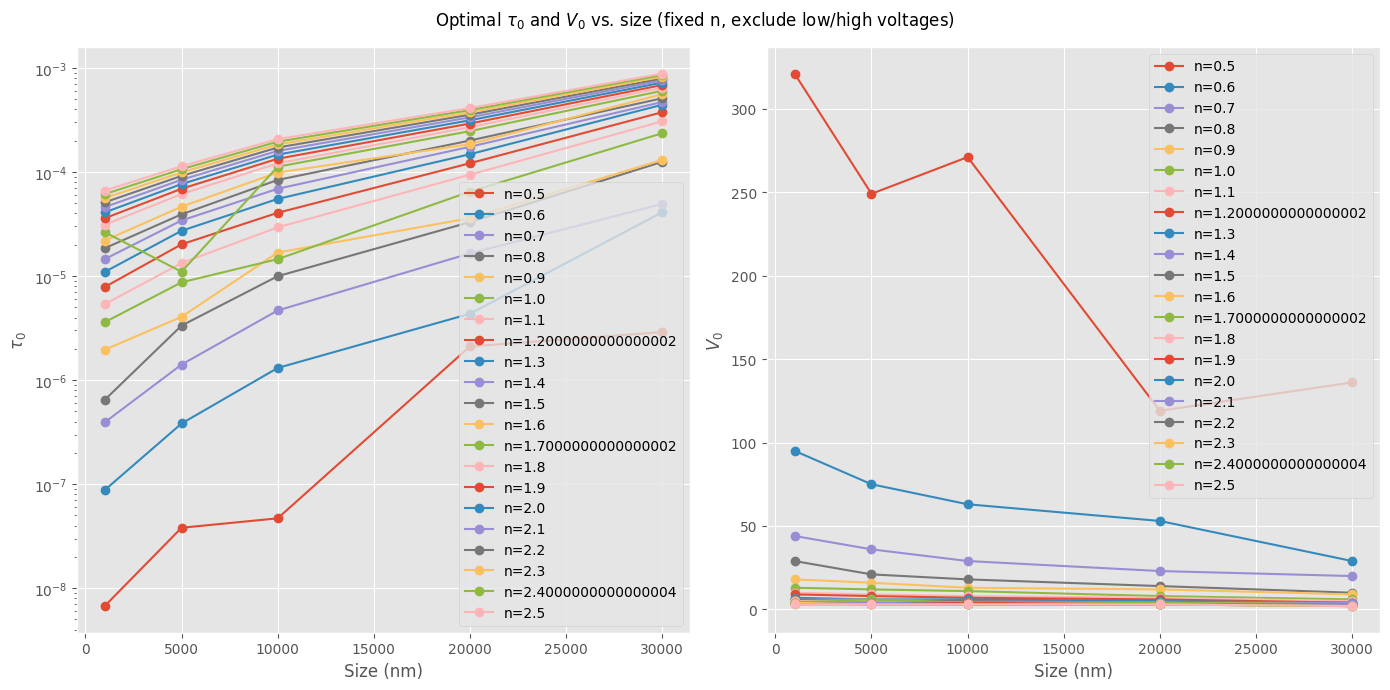

In [17]:
# plot_tau_vs_size(tau_fits_path, suptitle="Optimal $\\tau_0$ and $V_0$ vs. size", minsize=1000, savefig=os.path.join(results_subdir, "tauV0_vs_size.png"))
# plot_tau_vs_size(tau_fits_path_fixn, suptitle="Optimal $\\tau_0$ and $V_0$ vs. size (fixed n)", minsize=1000, savefig=os.path.join(results_subdir, "tauV0_vs_size_fixn.png"))
# plot_tau_vs_size(tau_fits_path_exclude3, suptitle="Optimal $\\tau_0$ and $V_0$ vs. size (exclude low/high voltages)", minsize=1000, savefig=os.path.join(results_subdir, "tauV0_vs_size_exclude3.png"))
plot_tau_vs_size(tau_fits_path, suptitle="Optimal $\\tau_0$ and $V_0$ vs. size (fixed n, exclude low/high voltages)",
                 minsize=1000, savefig=os.path.join(results_subdir, "tauV0_vs_size_fixn_exclude3.png"))

In [18]:
def plot_r2_vs_n(voltages_filename, tau_filename, exclude_voltages=None, minsize=0, suptitle="", savefig=None):
    # plot sum of R2 and R2 for log(tau) vs. voltage fit as function of n (fixed n and excluding low/high voltages only), for different sizes
    volt_df = pd.read_csv(voltages_filename)
    if exclude_voltages is not None:
        volt_df = volt_df[~volt_df['voltage'].isin(exclude_voltages)]
    volt_df = volt_df[volt_df['size'] >= minsize]
    volt_df.sort_values(by='n', ignore_index=True, inplace=True)

    tau_df = pd.read_csv(tau_filename)
    tau_df = tau_df[tau_df['size'] >= minsize]
    tau_df.sort_values(by='n', ignore_index=True, inplace=True)

    n_vals = tau_df['n'].unique()
    n_vals = sorted(n_vals)
    sizes = tau_df['size'].unique()
    sizes = sorted(sizes)

    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    fig.suptitle(suptitle)

    # Use a color palette with more colors
    # colors = plt.cm.plasma(np.linspace(0, 1, len(sizes)))
    colors = [f"C{i}" for i in range(len(sizes))]

    for size, color in zip(sizes, colors):
        # plot sum of r2 scores for polarization fit on the left
        size_volt_df = volt_df[volt_df['size'] == size]
        r2_sum = np.array(
            [np.sum(size_volt_df[np.isclose(size_volt_df['n'], n, atol=n_tol*1.1)]['r2_score']) for n in n_vals])
        r2_lens = np.array([len(size_volt_df[np.isclose(size_volt_df['n'], n, atol=n_tol*1.1)]) for n in n_vals])
        r2_sum_norm = r2_sum / r2_lens

        axs[0].plot(n_vals, r2_sum_norm, label=f"{size} nm", marker='o', color=color)

        # plot r2 scores for tau fit on the right
        size_tau_df = tau_df[tau_df['size'] == size]
        axs[1].plot(size_tau_df['n'], size_tau_df['r2_score'], label=f"{size} nm", marker='o', color=color)

    axs[0].set(xlabel='n', ylabel='[Normalized] Sum of $R^2$ scores for polarization fit')
    axs[0].legend()
    axs[1].set(xlabel='n', ylabel='$R^2$ score for $\\log(\\tau_{{Lorentz}})=f(1/V)$ fit')
    axs[1].legend()
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

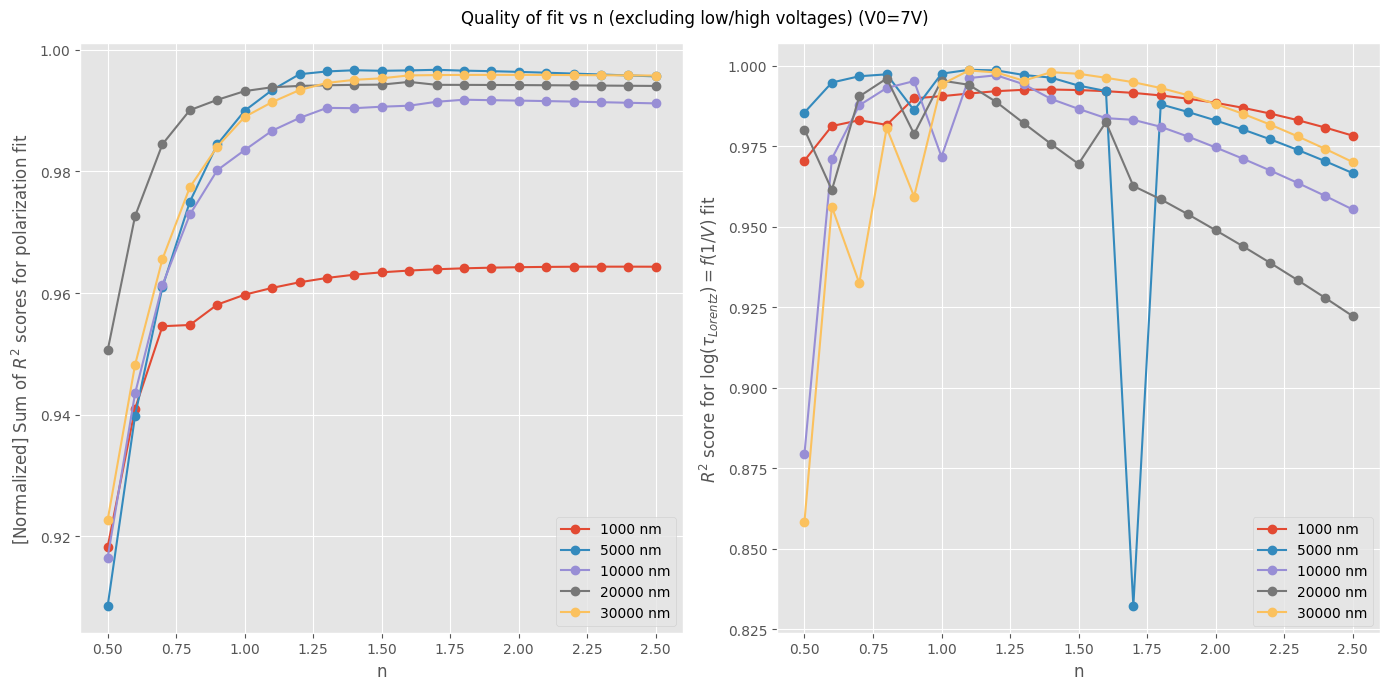

In [19]:
exclude_voltages = [1, 1.25, 1.5, 4.5, 4.75, 5]
plot_r2_vs_n(polarization_fits_path, tau_fits_path, exclude_voltages, minsize=1000,
             suptitle="Quality of fit vs n (excluding low/high voltages) (V0=7V)", savefig=os.path.join(results_subdir, "r2_vs_n.png"))

In [59]:
def format_SwitchingData():
    vlsi = pd.read_csv('/scratch/msc24h18/msc_project/data/VLSI_SwitchingData/VLSI_SwitchingData_PulseLength_Voltage_Normalized.txt', sep=' ')
    v = sorted(vlsi['v'].unique())
    t = sorted(vlsi['pulseTime'].unique())
    formatted_data = {"Pulse Width": t}
    for v_val in v:
        tmp = vlsi[vlsi['v'] == v_val]
        tmp.sort_values(by='pulseTime', ignore_index=True, inplace=True)

        s_vals = np.zeros_like(t)
        s_vals[:] = np.nan

        indices = [t.index(pulse_time) for pulse_time in tmp['pulseTime']]
        s_vals[indices] = tmp['S'].values

        formatted_data[f"{v_val:.2f}V"] = s_vals

    formatted_data = pd.DataFrame(formatted_data)
    formatted_data.to_csv('/scratch/msc24h18/msc_project/data/VLSI_SwitchingData/VLSI_SwitchingData_formatted.csv', index=False)

In [ ]:
# compare paul fit to Ruben's fit (n=2)

exp_data = pd.read_csv('/scratch/msc24h18/msc_project/data/VLSI_SwitchingData/VLSI_SwitchingData_formatted.csv')

ruben_fit = pd.read_csv('/scratch/msc24h18/msc_project/data/VLSI_SwitchingData/VLSI_SwitchingData_formatted_fit.csv')

paul_fit_params = pd.read_csv('/scratch/msc24h18/msc_project/results/nls_model/20250122_120729/polarization_fits.csv')
paul_fit_params = paul_fit_params[np.isclose(paul_fit_params['n'], 2, atol=0.11)]
paul_fit_data = {"Pulse Width": ruben_fit['Pulse Width']}

for col in ruben_fit.columns[1:]:
    popt = paul_fit_params[paul_fit_params['voltage'] == float(col.split('V')[0])].values
    if len(popt) == 0:
        continue
    popt = popt[0][2:-1]
    n, A, omega, log_tlorentz = popt
    p = polarization_lorentzian(ruben_fit['Pulse Width'], A, omega, log_tlorentz, n)
    paul_fit_data[col] = p

paul_fit_data = pd.DataFrame(paul_fit_data)

r2_comparison = {"voltage": [], "r2_ruben": [], "r2_paul": [], "difference": []}
for col in ruben_fit.columns[1:]:
    r2_ruben = r2_score(exp_data[col], ruben_fit[col])
    r2_paul = r2_score(exp_data[col], paul_fit_data[col])
    diff = r2_ruben - r2_paul
    r2_comparison["voltage"].append(col)
    r2_comparison["r2_ruben"].append(r2_ruben)
    r2_comparison["r2_paul"].append(r2_paul)
    r2_comparison["difference"].append(diff)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(exp_data['Pulse Width'], exp_data[col], label='Experimental data')
    ax.plot(ruben_fit['Pulse Width'], ruben_fit[col], label=f"Ruben's fit: $R^2$={r2_ruben:.3f}")
    ax.plot(paul_fit_data['Pulse Width'], paul_fit_data[col], label=f"Paul's fit: $R^2$={r2_paul:.3f}")
    ax.set(xlabel='Pulse duration', ylabel='Partial polarization', xscale='log', ylim=(0, 1), title=f'{col}: $R^2_{{Ruben}}-R^2_{{Paul}}$={diff:.3e}')
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'/scratch/msc24h18/msc_project/results/nls_model/20250122_120729/fit_comparison/V{col}.png')
    plt.show()

r2_comparison = pd.DataFrame(r2_comparison)
#r2_comparison.to_csv('/scratch/msc24h18/msc_project/results/nls_model/20250122_120729/r2_comparison.csv', index=False)